In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import os

%matplotlib inline 
sns.set(color_codes=True)

from dotenv import load_dotenv
from core_ds4a_project import cleaning, columns as project_columns, datasets

%load_ext autoreload
%autoreload 1
%aimport core_ds4a_project, core_ds4a_project.cleaning, core_ds4a_project.columns, core_ds4a_project.datasets

pd.set_option("display.max_columns", None)

In [2]:
import folium
import pingouin as pg
from folium.plugins import HeatMap

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [3]:
import statsmodels.formula.api as sm

Environment variables:

In [4]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'

Reading data:

In [5]:
(cartera_df, clientes_df, colocacion_df) = datasets.read_joining_datasets(dir_path=RAW_DATA_PATH)

Sorting CARTERA:

In [6]:
cartera_df = cartera_df.sort_values(['FECHA_CIERRE', 'OBLIGACION'], ascending=True)
ind_first = ~(cartera_df.duplicated(keep='first', subset='OBLIGACION'))
ind_last = ~(cartera_df.duplicated(keep='last', subset='OBLIGACION'))

<H2>Data for Modeling:</H2>

Lasts records by client:

In [7]:
lasts_records_cartera_df = cartera_df[ind_last].copy()
lasts_records_cartera_df.shape

(38641, 32)

In [8]:
lasts_records_cartera_df.head(5)

,OBLIGACION,CLIENTE,TIPO_CLIENTE_COD,TIPO_CLIENTE,REGION,MUNICIPIO_CLIENTE,VALOR_CUOTA,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,PERIODICIDAD_PAGO,CALIFICACION_CIERRE,MODALIDAD,SALDO,VENCIDA,DIAS_VENCIDO,CAPITAL_VEN,INTERES_VEN,MORA,SEGURO_VIDA,COMISION,OTROS,FECHA_ULT_PAGO,FECHA_PROXIMO_PAGO,FECHA_VENCIMIENTO_FINAL,PORCENTAJE_PAGO,TIPO_CREDITO,SUCURSAL_COD,FECHA_CIERRE,SUCURSAL_REAL,MUNICIPIO_LAT,MUNICIPIO_LON
210924,171000008,FA12448,1.0,Microfinanciero,REGION SUR,SABANALARGA,197638,12,12,2.64,Mensual,A,CREDITO RURAL INDIVIDUAL - GERMINA,2000000,-,0,-,-,-,-,0,0,2017-01-20,2017-02-19,2018-01-19,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.85430,-73.04003
210739,172000006,FA25175,1.0,Microfinanciero,REGION VILLAVICENCIO,VILLAVICENCIO,293974,36,36,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),6000000,-,0,-,-,-,-,0,0,NaT,2017-02-19,2020-01-19,100.0,RETANQUEADO,NaN,2017-01-31,VILLAVICENCIO,4.14200,-73.62664
210815,173000013,FA23399,1.0,Microfinanciero,REGION META,ACACIAS,183032,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2950000,-,0,-,-,-,-,0,0,NaT,2017-02-27,2019-01-27,100.0,NUEVO,NaN,2017-01-31,ACACIAS,3.98695,-73.75797
210887,176000015,FA19928,1.0,Microfinanciero,REGION META,GRANADA,179930,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2900000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2019-01-31,100.0,NUEVO,NaN,2017-01-31,GRANADA,3.54625,-73.70687
210843,177000008,FA227,1.0,Microfinanciero,REGION SUR,MONTERREY,103305,12,12,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),1000000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2018-01-31,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.87802,-72.89575


Creditos y Clientes con calificacion 'A'

In [9]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] == 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(33021, 19070)

Creditos y Clientes con calificacion diferente de 'A'

In [10]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] != 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(5620, 5487)

Creditos con variable indicando la peor calificación durante la vigencia del mismo:

In [11]:
calificacion_by_obligacion = cartera_df.groupby(by=['OBLIGACION'])['CALIFICACION_CIERRE']
calificacion_worst = calificacion_by_obligacion.max().rename('CALIFICACION_PEOR')
colocacion_df = colocacion_df.merge(
  calificacion_worst.reset_index(),
  on="OBLIGACION"
)

In [12]:
colocacion_df['IDEAL'] = colocacion_df['CALIFICACION_PEOR'] == 'A'

In [13]:
colocacion_df[['OBLIGACION', 'CALIFICACION_PEOR', 'IDEAL']]

,OBLIGACION,CALIFICACION_PEOR,IDEAL
0,219000654,A,True
1,197002188,A,True
2,218000181,A,True
3,218000180,A,True
4,2112000110,A,True
...,...,...,...
38636,178000003,B,False
38637,1710000001,C,False
38638,178000001,A,True
38639,171000001,A,True


In [14]:
model1_df = pd.merge(lasts_records_cartera_df, colocacion_df, how='left', on="OBLIGACION", suffixes=('_left', '_right'))
model1_df.shape

(38641, 59)

In [15]:
model1_df = model1_df.rename(columns={'CLIENTE_left':'CLIENTE',
                                      'VALOR_CUOTA_left':'VALOR_CUOTA'
                                     })

In [16]:
model_df = pd.merge(model1_df, clientes_df, how='left', on="CLIENTE", suffixes=('_left_model', '_right_client'))
model_df.shape

(38641, 85)

In [17]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [18]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos
22,FECHA_ULT_PAGO,3034
27,SUCURSAL_COD,8
29,SUCURSAL_REAL,12
30,MUNICIPIO_LAT,88
31,MUNICIPIO_LON,88
43,OBSERVACIONES,644
53,CREDITOS_VIGENTES,19887
56,DEFAULT,37678
60,ESTRATO,54
61,SUCURSAL,1


<H2>Feature Engineer</H2>

In [19]:
model_df['DEFAULT'].unique()

array([nan, True], dtype=object)

In [20]:
idx = model_df["DEFAULT"] != True
model_df.loc[idx,'DEFAULT'] = 0

idx = model_df["DEFAULT"] == True
model_df.loc[idx,'DEFAULT'] = 1

model_df['DEFAULT'] = model_df['DEFAULT'].astype('int64')

model_df['DEFAULT'].unique()

array([0, 1], dtype=int64)

In [21]:
idx = model_df["IDEAL"] != True
model_df.loc[idx,'IDEAL'] = 0

idx = model_df["IDEAL"] == True
model_df.loc[idx,'IDEAL'] = 1

model_df['IDEAL'] = model_df['IDEAL'].astype('int64')

model_df['IDEAL'].unique()

array([1, 0], dtype=int64)

- Mes(n-3) Credit 1 Q=A
- Mes(n-2) Credit 1 Q=A
- Mes(n-1) Credit 1 Q=B  ---- ultimo  -> DEFAULT_Q = 1

- Mes(n-1) Credito 2 Q=A ---- ultimo  -> DEFAULT_Q = 0

model_df['DEFAULT_Q'] = 0
nok = model_df["CALIFICACION_CIERRE"] != "A"
model_df.loc[nok,'DEFAULT_Q'] = 1

model_df.loc[nok,'DEFAULT_Q']

In [22]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [23]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos
22,FECHA_ULT_PAGO,3034
27,SUCURSAL_COD,8
29,SUCURSAL_REAL,12
30,MUNICIPIO_LAT,88
31,MUNICIPIO_LON,88
43,OBSERVACIONES,644
53,CREDITOS_VIGENTES,19887
60,ESTRATO,54
61,SUCURSAL,1
64,ACTIVIDAD_ECONOMICA,251


In [24]:
len(model_df.loc[model_df['DEFAULT'] == 1])

963

In [25]:
len(model_df.loc[model_df['DEFAULT'] == 0])

37678

Looking at correlations:

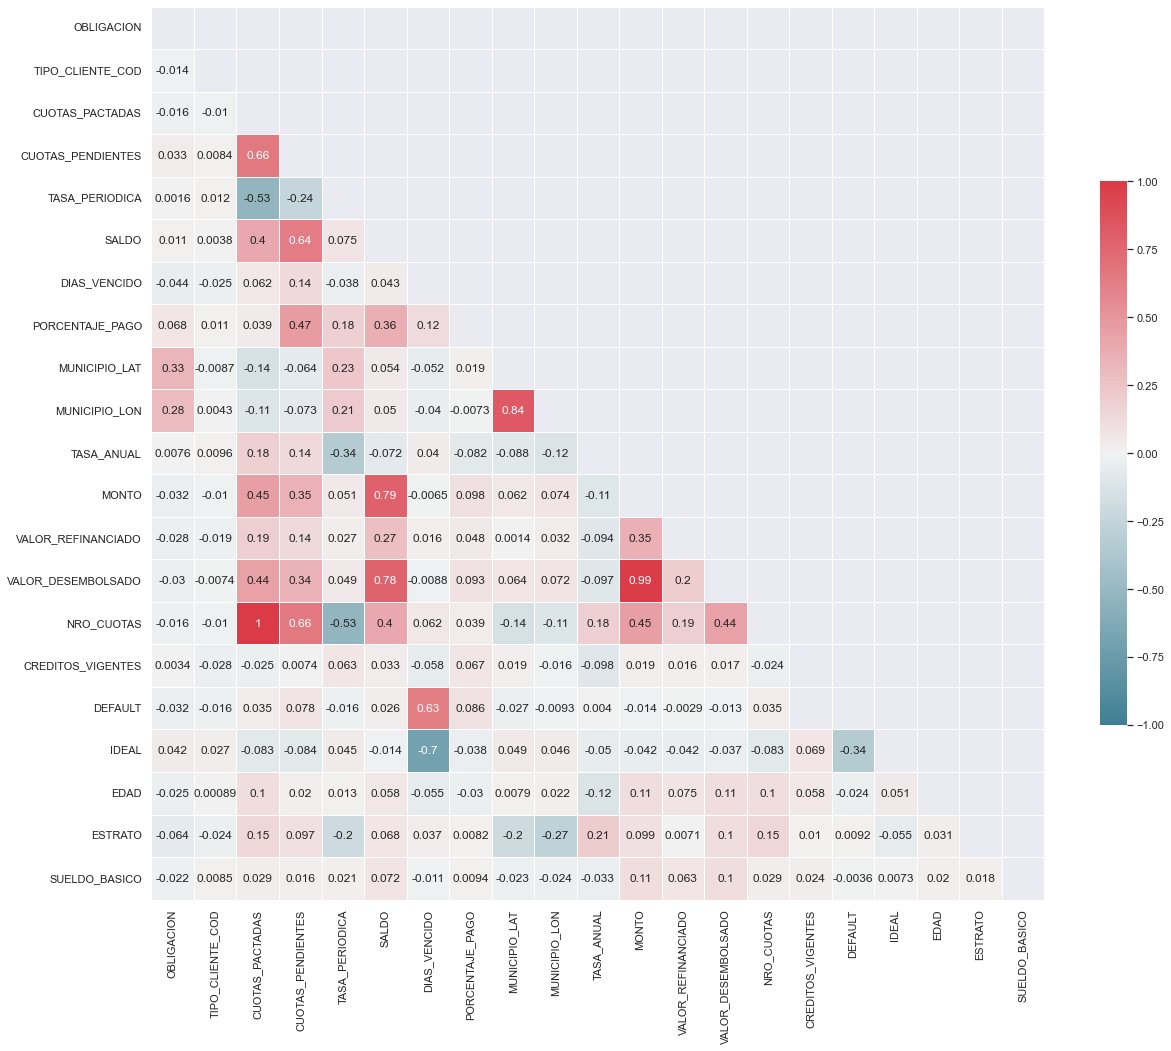

In [26]:
#compute correlation matrix
df_correlations = model_df.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,
            mask=mask,  
            vmax=1, 
            vmin=-1, 
            cmap=cmap, 
            center=0,
            annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Split our data into training and testing sets (an 80-20 split is a good starting point):

In [27]:
np.random.seed(1234) # a seed makes the analysis reproducible
                     # so everyone will get the same results

n_data = len(model_df)

# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(n_data), int(0.8*n_data), replace=False)

# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(n_data)) - set(idx_train)))

df_train     = model_df.iloc[idx_train] # the training data set
df_test      = model_df.iloc[idx_test]  # the test data set

print(df_train.shape) 
print(df_test.shape)  

(30912, 85)
(7729, 85)


In [28]:
len(df_train.loc[df_train['DEFAULT'] == 1])

780

In [29]:
len(df_train.loc[df_train['DEFAULT'] == 0])

30132

In [30]:
df_train.shape

(30912, 85)

In [31]:
df_train.dropna().shape

(3382, 85)

<H2> MODEL 1: Multiple linear regression </H2>

Regression model for estimating the amount's loan as a function of some variables like age, education level, etc. 

## Loan amount recommendation model

In [60]:
import joblib

In [61]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL) + C(OFICIO) + C(EDAD) + C(ESTRATO) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + C(NRO_CUOTAS) + C(OCUPACION) + '\
                       + 'C(TIPO_UBICACION) + C(RESPONSABLE_DE_HOGAR) + C(NIVEL_ESTUDIOS) + '\
                       + 'np.log(SUELDO_BASICO) + np.log(TASA_ANUAL) + np.log(CREDITOS_VIGENTES)'
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     7.007
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          1.40e-143
Time:                        14:33:26   Log-Likelihood:                -529.11
No. Observations:                1451   AIC:                             2180.
Df Residuals:                     890   BIC:                             5142.
Df Model:                         560                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [63]:
joblib.dump(model_lin, './model_monto')

['./model_monto']

In [68]:
model_lin.rsquared

0.8151269405347122

In [69]:
model_lin.aic

2180.2102234450604

Variables from our model are statistically significant:

In [35]:
alpha = 0.05                  # level of significance / type-I error rate
m = len(model_lin.pvalues)    # number of tests
significant = np.sum(model_lin.pvalues  < alpha)
significant, m

(516, 989)

In [36]:
model_lin.pvalues

Intercept                             7.550079e-18
C(ESTADO_CIVIL)[T.Divorciado]         1.807898e-01
C(ESTADO_CIVIL)[T.Otro]               1.163676e-04
C(ESTADO_CIVIL)[T.Soltero]            1.039477e-03
C(ESTADO_CIVIL)[T.Union libre]        5.932494e-01
                                          ...     
C(NIVEL_ESTUDIOS)[T.Tecnológica]      3.337163e-02
C(NIVEL_ESTUDIOS)[T.Universitaria]    2.904427e-01
np.log(SUELDO_BASICO)                 1.224978e-21
np.log(TASA_ANUAL)                    5.374621e-03
np.log(CREDITOS_VIGENTES)             9.166196e-01
Length: 989, dtype: float64

In [37]:
model_lin.params

Intercept                             1.070536e+01
C(ESTADO_CIVIL)[T.Divorciado]        -2.146250e-01
C(ESTADO_CIVIL)[T.Otro]              -8.053139e-13
C(ESTADO_CIVIL)[T.Soltero]           -2.433469e-01
C(ESTADO_CIVIL)[T.Union libre]        3.334442e-02
                                          ...     
C(NIVEL_ESTUDIOS)[T.Tecnológica]      8.871821e-01
C(NIVEL_ESTUDIOS)[T.Universitaria]    4.206616e-01
np.log(SUELDO_BASICO)                 4.221011e-01
np.log(TASA_ANUAL)                   -4.808889e-01
np.log(CREDITOS_VIGENTES)            -1.081803e-02
Length: 989, dtype: float64

____________

## Test loan amount recommendation

In [38]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0 & CALIFICACION_CIERRE=="A"')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     6.831
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           4.35e-65
Time:                        14:18:26   Log-Likelihood:                -2891.2
No. Observations:                2621   AIC:                             5952.
Df Residuals:                    2536   BIC:                             6451.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [39]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL) + C(OFICIO) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION)  + C(RESPONSABLE_DE_HOGAR) + C(NIVEL_ESTUDIOS_COD) + '\
                       + 'C(GENERO_COD) + C(ESTRATO) + np.log(SUELDO_BASICO) + np.log(EDAD) '
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO +  C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0 & CALIFICACION_CIERRE=="A"')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     5.706
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          4.39e-195
Time:                        14:18:27   Log-Likelihood:                -1328.6
No. Observations:                2448   AIC:                             4259.
Df Residuals:                    1647   BIC:                             8907.
Df Model:                         800                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [40]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.482
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           2.37e-75
Time:                        14:19:03   Log-Likelihood:                -3286.2
No. Observations:                2995   AIC:                             6744.
Df Residuals:                    2909   BIC:                             7261.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [41]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     33.83
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:19:27   Log-Likelihood:                -32046.
No. Observations:               29267   AIC:                         6.429e+04
Df Residuals:                   29166   BIC:                         6.513e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

## "Default" prediction model

In [58]:
formula_lin1 = 'DEFAULT ~  np.log(MONTO) + C(NRO_CUOTAS) + C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + C(CALIFICACION_CIERRE) + '\
                       + 'C(TIPO_UBICACION) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO) + C(ESTRATO) + SUELDO_BASICO + EDAD + np.log(TASA_ANUAL) + C(NIVEL_ESTUDIOS)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     49.74
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:24:51   Log-Likelihood:                 15871.
No. Observations:               28718   AIC:                        -3.138e+04
Df Residuals:                   28539   BIC:                        -2.990e+04
Df Model:                         178                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [43]:
model_lin1.rsquared

0.23677699988607204

In [46]:
model_lin1.aic

-31383.88207634454

In [47]:
model_lin1.pvalues

Intercept                             0.160620
C(NRO_CUOTAS)[T.2]                    0.802129
C(NRO_CUOTAS)[T.3]                    0.384423
C(NRO_CUOTAS)[T.4]                    0.042234
C(NRO_CUOTAS)[T.5]                    0.076510
                                        ...   
C(NIVEL_ESTUDIOS)[T.Universitaria]    0.558040
np.log(MONTO)                         0.001892
SUELDO_BASICO                         0.625797
EDAD                                  0.542511
np.log(TASA_ANUAL)                    0.000116
Length: 181, dtype: float64

In [48]:
alpha = 0.05                   # level of significance / type-I error rate
m = len(model_lin1.pvalues)    # number of tests
significant = np.sum(model_lin1.pvalues  < alpha)
significant, m

(30, 181)

In [49]:
model_lin1.params

Intercept                             2.090057e-01
C(NRO_CUOTAS)[T.2]                   -2.653445e-03
C(NRO_CUOTAS)[T.3]                   -9.055769e-03
C(NRO_CUOTAS)[T.4]                    1.313065e-02
C(NRO_CUOTAS)[T.5]                   -1.566186e-02
                                          ...     
C(NIVEL_ESTUDIOS)[T.Universitaria]    6.448806e-03
np.log(MONTO)                        -4.710498e-03
SUELDO_BASICO                         2.745086e-10
EDAD                                  4.918701e-05
np.log(TASA_ANUAL)                   -4.482332e-02
Length: 181, dtype: float64

____________

## Test - "Default" prediction model

In [50]:
formula_lin1 = 'DEFAULT ~  C(ESTADO_CIVIL) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'np.log(MONTO) + C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO) + C(ESTRATO) + np.log(SUELDO_BASICO) + C(EDAD) + np.log(TASA_ANUAL) + C(NIVEL_ESTUDIOS)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.177
Date:                Thu, 07 Jul 2022   Prob (F-statistic):             0.0535
Time:                        14:20:43   Log-Likelihood:                 1633.5
No. Observations:                2902   AIC:                            -2881.
Df Residuals:                    2709   BIC:                            -1728.
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

____________

In [51]:
formula_lin1 = 'DEFAULT ~  np.log(MONTO) + C(ESTADO_CIVIL) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(CUOTAS_PENDIENTES) + '\
                       + 'C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO) + C(ESTRATO) + SUELDO_BASICO + EDAD + TASA_ANUAL + C(NIVEL_ESTUDIOS)'
#                      + 'C(CALIFICACION_CIERRE)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.893
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           4.15e-11
Time:                        14:20:45   Log-Likelihood:                 1689.4
No. Observations:                2902   AIC:                            -3015.
Df Residuals:                    2720   BIC:                            -1928.
Df Model:                         181                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [52]:
model_lin1.rsquared

0.11189519961217487

In [53]:
model_lin1.aic

-3014.839457113657

Variables from our model are statistically significant:

In [54]:
alpha = 0.05                  # level of significance / type-I error rate
m = len(model_lin1.pvalues)    # number of tests
significant = np.sum(model_lin1.pvalues  < alpha)
significant, m

(23, 190)

In [55]:
model_lin1.params

Intercept                             2.897743e-01
C(ESTADO_CIVIL)[T.Divorciado]        -6.491266e-03
C(ESTADO_CIVIL)[T.Otro]              -8.277904e-02
C(ESTADO_CIVIL)[T.Soltero]           -5.330370e-03
C(ESTADO_CIVIL)[T.Union libre]        7.762819e-03
                                          ...     
C(NIVEL_ESTUDIOS)[T.Universitaria]   -1.114697e-02
np.log(MONTO)                        -1.028307e-02
SUELDO_BASICO                         4.639602e-10
EDAD                                  1.817967e-05
TASA_ANUAL                            9.197346e-05
Length: 190, dtype: float64

In [56]:
model_lin1.pvalues

Intercept                             0.004427
C(ESTADO_CIVIL)[T.Divorciado]         0.692146
C(ESTADO_CIVIL)[T.Otro]               0.423789
C(ESTADO_CIVIL)[T.Soltero]            0.513793
C(ESTADO_CIVIL)[T.Union libre]        0.281968
                                        ...   
C(NIVEL_ESTUDIOS)[T.Universitaria]    0.752118
np.log(MONTO)                         0.036770
SUELDO_BASICO                         0.583616
EDAD                                  0.945835
TASA_ANUAL                            0.935810
Length: 190, dtype: float64